In [690]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score




In [691]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Combine Tables

In [692]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [693]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [694]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [695]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [696]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [697]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [698]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [699]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


### Combine the tables: Join at Lowest Common Denominator (transaction level)

This option is a bit more tricky because we need to join at a customer ID, but also map the dates between the marketing campaign and subsequent purchase. We would want to see which marketing campaign was sent to the user before they made a transaction.

In [700]:
# step 1: make transactions and marketing indexes as customer_id for easy joining
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)
transactions.set_index('customer_id', inplace=True)
marketing.set_index('customer_id', inplace=True)

In [701]:
# now we CANNOT join the full data directly because this will result in DUPLICATES
# DON'T do this > I'm just demonstrating what will happen - you can see below an example of user 1
customers.join(engagement).join(marketing).join(transactions).loc[1]

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_id,response,promotion_type,campaign_date,transaction_id,transaction_date,transaction_amount,product_category
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,1,2024-02-03,165.56,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,2,2024-03-02,699.01,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,3,2024-03-12,146.86,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,4,2024-01-20,927.46,Electronics
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,5,2024-02-25,1395.87,Electronics
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,6,2024-01-09,174.72,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,1,2024-02-03,165.56,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,2,2024-03-02,699.01,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,3,2024-03-12,146.86,Home Goods


In [702]:
# instead; for the transactions and marketing tables, we need to align the marketing campaign dates with the transactions
# in other words > which marketing campaign was the user exposed to before they made a transaction?
# and did they respond positively or negatively to that?
# we need to convert key dates to datetime objects

marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [703]:
# now we can use the merge() function in combination with the joins
# join the first 3 tables

transaction_level = customers.join(engagement).join(transactions)

In [704]:
# reset index
transaction_level.reset_index(inplace=True)

In [705]:
# reset index
marketing.reset_index(inplace=True)

In [706]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [707]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [708]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [709]:
# make sure sorting is correct
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [710]:
# make sure date datatype is correct
marketing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25200 entries, 3 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.2+ MB


In [711]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [712]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [713]:
# double check marketing aligns
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [714]:
# double check transactions are correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


# Data Cleaning

In [715]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [716]:
# Get unique values
unique_customer_ids = df_merged['campaign_customer_id'].unique()

# Check if the value 0 exists
has_zero = 0 in unique_customer_ids

print(f"Unique customer IDs: {unique_customer_ids}")
print(f"Does campaign_customer_id contain 0? {has_zero}")

Unique customer IDs: [      nan 1.000e+00 2.000e+00 ... 9.998e+03 9.999e+03 1.000e+04]
Does campaign_customer_id contain 0? False


In [717]:
# Get unique values
unique_campaign_ids = df_merged['campaign_campaign_id'].unique()

# Check if the value 0 exists
has_zero = 0 in unique_campaign_ids

print(f"Unique campaign IDs: {unique_campaign_ids}")
print(f"Does campaign_campaign_id contain 0? {has_zero}")


Unique campaign IDs: [       nan 4.0000e+00 2.0000e+00 ... 2.5198e+04 2.5197e+04 2.5200e+04]
Does campaign_campaign_id contain 0? False


In [718]:
df_merged['campaign_response'].unique()

array([None, 'Yes', 'No'], dtype=object)

In [719]:
df_merged['campaign_campaign_date'].unique()

<DatetimeArray>
[                'NaT', '2024-01-10 00:00:00', '2024-01-24 00:00:00',
 '2024-02-29 00:00:00', '2024-03-05 00:00:00', '2021-11-12 00:00:00',
 '2022-07-08 00:00:00', '2021-11-15 00:00:00', '2022-08-11 00:00:00',
 '2022-03-02 00:00:00',
 ...
 '2020-04-17 00:00:00', '2020-02-10 00:00:00', '2020-02-15 00:00:00',
 '2020-02-11 00:00:00', '2020-03-03 00:00:00', '2020-05-04 00:00:00',
 '2020-03-09 00:00:00', '2020-04-02 00:00:00', '2020-02-22 00:00:00',
 '2020-05-16 00:00:00']
Length: 1588, dtype: datetime64[ns]

In [720]:
# check missing value
missing_values = df_merged.isnull().sum()
print(missing_values)

customer_id                    0
join_date                      0
last_purchase_date             0
age                        13082
gender                      7020
location                       0
number_of_site_visits          0
number_of_emails_opened        0
number_of_clicks               0
transaction_id                 0
transaction_date               0
transaction_amount             0
product_category               0
campaign_customer_id       39556
campaign_campaign_id       39556
campaign_response          39556
campaign_promotion_type    39556
campaign_campaign_date     39556
dtype: int64


In [721]:
# Fill missing values ​​with specific values
df_merged['age'].fillna(method='ffill', inplace=True)
df_merged['gender'].fillna('Prefer not to say', inplace=True)
df_merged['campaign_customer_id'].fillna(0.0, inplace=True)
df_merged['campaign_campaign_id'].fillna(0.0, inplace=True)
df_merged['campaign_response'].fillna('Not Available', inplace=True)
df_merged['campaign_promotion_type'].fillna('Not Available', inplace=True)
df_merged['campaign_campaign_date'].fillna('Not Available', inplace=True)

# Check missing values 
missing_values_after = df_merged.isnull().sum()
print(missing_values_after)

/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_17196/2288352175.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['age'].fillna(method='ffill', inplace=True)
/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_17196/2288352175.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['age'].fillna(method='ffill', inplace=True)
/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_17196/2288352175.py:

customer_id                0
join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_date           0
transaction_amount         0
product_category           0
campaign_customer_id       0
campaign_campaign_id       0
campaign_response          0
campaign_promotion_type    0
campaign_campaign_date     0
dtype: int64


In [722]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      129545 non-null  float64       
 4   gender                   129545 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

# Feature Engeering

### Calculating LTV
Lifetime Value is the TOTAL value the customer has brought to a company in their lifetime. This is simply a SUM of all their transactions.

Hint: you can calculate the lifetime (or age) of the customer by looking at their last transaction date vs. their join date. Be sure to use the correct data types.

In [723]:
df_merged.head() 

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,0.0,0.0,Not Available,Not Available,Not Available
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10 00:00:00
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24 00:00:00
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24 00:00:00
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29 00:00:00


In [724]:
# Calculate the total transaction amount for each customer
total_amount_per_customer = df_merged.groupby('customer_id')['transaction_amount'].sum()

# Calculating customer lifecycle
first_purchase = transactions.groupby('customer_id')['transaction_date'].min()
last_purchase = transactions.groupby('customer_id')['transaction_date'].max()
customer_lifetime = (last_purchase - first_purchase).dt.days + 1

customer_lifetime_months = customer_lifetime / 30

# Calculate average purchase frequency
purchase_times = df_merged.groupby('customer_id').size()
purchase_frequency = purchase_times / customer_lifetime
purchase_frequency_month = purchase_times / customer_lifetime_months


# Calculate the average value of each purchase
average_order_value = total_amount_per_customer / purchase_times

# CLV
clv = average_order_value * purchase_frequency * customer_lifetime


# Merge results
Clv = pd.DataFrame({
    'total_amount': total_amount_per_customer,
    'customer_lifetime': customer_lifetime,
    'customer_lifetime_months': customer_lifetime_months,
    'purchase_times': purchase_times,
    'purchase_frequency': purchase_frequency,
    'purchase_frequency_month': purchase_frequency_month,
    'average_order_value': average_order_value,
    'clv': clv
})

Clv

,total_amount,customer_lifetime,customer_lifetime_months,purchase_times,purchase_frequency,purchase_frequency_month,average_order_value,clv
customer_id,,,,,,,,
1,3509.48,64,2.133333,6,0.093750,2.812500,584.913333,3509.48
2,6081.32,516,17.200000,9,0.017442,0.523256,675.702222,6081.32
3,1454.87,417,13.900000,6,0.014388,0.431655,242.478333,1454.87
4,7874.68,233,7.766667,20,0.085837,2.575107,393.734000,7874.68
5,15524.55,457,15.233333,24,0.052516,1.575492,646.856250,15524.55
...,...,...,...,...,...,...,...,...
9996,5498.20,162,5.400000,10,0.061728,1.851852,549.820000,5498.20
9997,5848.30,147,4.900000,12,0.081633,2.448980,487.358333,5848.30
9998,3503.13,50,1.666667,3,0.060000,1.800000,1167.710000,3503.13


In [725]:
Clv.describe()

,total_amount,customer_lifetime,customer_lifetime_months,purchase_times,purchase_frequency,purchase_frequency_month,average_order_value,clv
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7737.562981,309.464900,10.315497,12.954500,0.369265,11.077962,599.842451,7737.562981
std,4628.799469,303.064036,10.102135,7.191203,1.577773,47.333195,197.350557,4628.799469
min,23.810000,1.000000,0.033333,1.000000,0.001613,0.048387,23.810000,23.810000
25%,3839.915000,65.000000,2.166667,7.000000,0.024793,0.743802,488.343409,3839.915000
50%,7498.890000,212.000000,7.066667,13.000000,0.055556,1.666667,587.587333,7498.890000
75%,11275.797500,473.000000,15.766667,19.000000,0.175850,5.275488,692.701750,11275.797500
max,24298.220000,1514.000000,50.466667,25.000000,25.000000,750.000000,1997.080000,24298.220000


In [726]:
# Step 1: Calculate RFM metrics
# Recency: 
recency = customer_lifetime

# Frequency
frequency = purchase_frequency_month

# Monetary
monetary = total_amount_per_customer

# Step 2: Create RFM DataFrame
rfm = pd.DataFrame({
    'recency': recency,
    'frequency': frequency,
    'monetary': monetary
})

# Step 3: Calculate RFM scores with range 1-3
rfm['recency_score'] = pd.qcut(rfm['recency'], 3, labels=[3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 3, labels=[1, 2, 3])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 3, labels=[1, 2, 3])

# Step 4: Calculate RFM group
rfm['RFM_Score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

# Step 5: Assign segment labels
rfm['segment'] = 'Low-Value'
rfm.loc[rfm['RFM_Score'].isin(['333', '332', '323', '233', '333']), 'segment'] = 'High-Value'

# Display the RFM DataFrame
print(rfm.head())

# Step 6: Merge RFM segments back to the CLV DataFrame
Clv['segment'] = rfm['segment']

# Display the final DataFrame with CLV and RFM segments
Clv.head()

             recency  frequency  monetary recency_score frequency_score  \
customer_id                                                               
1                 64   2.812500   3509.48             3               2   
2                516   0.523256   6081.32             1               1   
3                417   0.431655   1454.87             1               1   
4                233   2.575107   7874.68             2               2   
5                457   1.575492  15524.55             1               2   

            monetary_score RFM_Score    segment  
customer_id                                      
1                        1       321  Low-Value  
2                        2       112  Low-Value  
3                        1       111  Low-Value  
4                        2       222  Low-Value  
5                        3       123  Low-Value  


,total_amount,customer_lifetime,customer_lifetime_months,purchase_times,purchase_frequency,purchase_frequency_month,average_order_value,clv,segment
customer_id,,,,,,,,,
1,3509.48,64,2.133333,6,0.093750,2.812500,584.913333,3509.48,Low-Value
2,6081.32,516,17.200000,9,0.017442,0.523256,675.702222,6081.32,Low-Value
3,1454.87,417,13.900000,6,0.014388,0.431655,242.478333,1454.87,Low-Value
4,7874.68,233,7.766667,20,0.085837,2.575107,393.734000,7874.68,Low-Value
5,15524.55,457,15.233333,24,0.052516,1.575492,646.856250,15524.55,Low-Value


In [727]:
Clv[Clv['segment'] == 'High-Value'].count()

total_amount                2183
customer_lifetime           2183
customer_lifetime_months    2183
purchase_times              2183
purchase_frequency          2183
purchase_frequency_month    2183
average_order_value         2183
clv                         2183
segment                     2183
dtype: int64

In [728]:
df = df_merged.merge(Clv, on='customer_id', how='left')

In [729]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_id               129545 non-null  int64         
 1   join_date                 129545 non-null  object        
 2   last_purchase_date        129545 non-null  object        
 3   age                       129545 non-null  float64       
 4   gender                    129545 non-null  object        
 5   location                  129545 non-null  object        
 6   number_of_site_visits     129545 non-null  int64         
 7   number_of_emails_opened   129545 non-null  int64         
 8   number_of_clicks          129545 non-null  int64         
 9   transaction_id            129545 non-null  int64         
 10  transaction_date          129545 non-null  datetime64[ns]
 11  transaction_amount        129545 non-null  float64       
 12  pr

In [730]:
# Drop columns
df_final = df.drop(columns=['transaction_id', 'campaign_campaign_date','campaign_response','campaign_customer_id'])

In [731]:
df_final.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_date', 'transaction_amount',
       'product_category', 'campaign_campaign_id', 'campaign_promotion_type',
       'total_amount', 'customer_lifetime', 'customer_lifetime_months',
       'purchase_times', 'purchase_frequency', 'purchase_frequency_month',
       'average_order_value', 'clv', 'segment'],
      dtype='object')

In [732]:
# Turned into 1 and 0
df_final['outcome'] = df_final['segment'].apply(lambda x: 1 if x == 'High-Value' else 0)

# Select the categorical variables that need to be converted into dummy variables
cat_col = ['gender', 'product_category', 'campaign_promotion_type']

# Convert categorical variables into dummy variables
df_final = pd.get_dummies(df_final, columns=cat_col, drop_first=False, dtype=int)

df_final

,customer_id,join_date,last_purchase_date,age,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_date,transaction_amount,...,gender_Female,gender_Male,gender_Prefer not to say,product_category_Clothing,product_category_Electronics,product_category_Home Goods,campaign_promotion_type_Buy One Get One,campaign_promotion_type_Discount,campaign_promotion_type_Free Shipping,campaign_promotion_type_Not Available
0,1,2023-11-20,2024-03-17,56.0,North Shannonbury,10,15,1,2024-01-09,174.72,...,1,0,0,1,0,0,0,0,0,1
1,1,2023-11-20,2024-03-17,56.0,North Shannonbury,10,15,1,2024-01-20,927.46,...,1,0,0,0,1,0,1,0,0,0
2,1,2023-11-20,2024-03-17,56.0,North Shannonbury,10,15,1,2024-02-03,165.56,...,1,0,0,1,0,0,0,1,0,0
3,1,2023-11-20,2024-03-17,56.0,North Shannonbury,10,15,1,2024-02-25,1395.87,...,1,0,0,0,1,0,0,1,0,0
4,1,2023-11-20,2024-03-17,56.0,North Shannonbury,10,15,1,2024-03-02,699.01,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129540,10000,2023-05-26,2023-09-01,67.0,Hollytown,12,12,7,2023-07-03,452.07,...,0,1,0,0,0,1,0,1,0,0
129541,10000,2023-05-26,2023-09-01,67.0,Hollytown,12,12,7,2023-07-20,310.95,...,0,1,0,1,0,0,0,1,0,0
129542,10000,2023-05-26,2023-09-01,67.0,Hollytown,12,12,7,2023-07-21,587.37,...,0,1,0,0,0,1,0,1,0,0
129543,10000,2023-05-26,2023-09-01,67.0,Hollytown,12,12,7,2023-08-03,34.85,...,0,1,0,0,0,1,0,1,0,0


In [733]:
df_final.drop(columns=['join_date', 'last_purchase_date','age','location','number_of_site_visits', 'number_of_emails_opened',
                       'transaction_date', 'transaction_amount', 'campaign_campaign_id',
       'total_amount', 'customer_lifetime', 'customer_lifetime_months',
       'purchase_times', 'purchase_frequency','purchase_frequency_month',
       'average_order_value', 'clv', 'segment', 'outcome'])

,customer_id,number_of_clicks,gender_Female,gender_Male,gender_Prefer not to say,product_category_Clothing,product_category_Electronics,product_category_Home Goods,campaign_promotion_type_Buy One Get One,campaign_promotion_type_Discount,campaign_promotion_type_Free Shipping,campaign_promotion_type_Not Available
0,1,1,1,0,0,1,0,0,0,0,0,1
1,1,1,1,0,0,0,1,0,1,0,0,0
2,1,1,1,0,0,1,0,0,0,1,0,0
3,1,1,1,0,0,0,1,0,0,1,0,0
4,1,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
129540,10000,7,0,1,0,0,0,1,0,1,0,0
129541,10000,7,0,1,0,1,0,0,0,1,0,0
129542,10000,7,0,1,0,0,0,1,0,1,0,0
129543,10000,7,0,1,0,0,0,1,0,1,0,0


In [734]:
# Define the columns that will be summed and the ones to keep directly
columns_to_sum = [ 'product_category_Clothing',
       'product_category_Electronics', 'product_category_Home Goods',
       'campaign_promotion_type_Buy One Get One',
       'campaign_promotion_type_Discount',
       'campaign_promotion_type_Free Shipping',
       'campaign_promotion_type_Not Available']
columns_to_keep = ['number_of_clicks','gender_Female','gender_Male', 'gender_Prefer not to say','join_date', 'number_of_site_visits', 
                   'number_of_emails_opened', 'total_amount','last_purchase_date', 'age', 'location', 'customer_lifetime',
                   'customer_lifetime_months', 'purchase_times', 'purchase_frequency', 'purchase_frequency_month',
                   'average_order_value', 'clv', 'segment', 'outcome']


In [735]:
# 按 'customer_id' 分组，并对指定列求和，对其他列取第一个值
df_grouped = df_final.groupby('customer_id').agg(
    {**{col: 'sum' for col in columns_to_sum},
     **{col: 'first' for col in columns_to_keep},
     'outcome': 'max'}
).reset_index()

In [736]:
# 确保没有重复的列
df_grouped = df_grouped.loc[:,~df_grouped.columns.duplicated()]

In [737]:
# 删除不需要的列
columns_to_drop = ['transaction_date', 'transaction_amount', 'campaign_campaign_id', 'purchase_frequency_month']
df_grouped.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [738]:
df_grouped['number_of_clicks']

0        1
1       51
2       25
3       17
4        7
        ..
9995    16
9996    14
9997     5
9998     4
9999     7
Name: number_of_clicks, Length: 10000, dtype: int64

# EDA

In [739]:
df_final.describe()

,customer_id,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_date,transaction_amount,campaign_campaign_id,total_amount,customer_lifetime,...,gender_Female,gender_Male,gender_Prefer not to say,product_category_Clothing,product_category_Electronics,product_category_Home Goods,campaign_promotion_type_Buy One Get One,campaign_promotion_type_Discount,campaign_promotion_type_Free Shipping,campaign_promotion_type_Not Available
count,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545,129545.000000,129545.000000,129545.000000,129545.000000,...,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000
mean,4998.806237,43.533938,99.471218,39.685291,19.569362,2022-10-04 21:22:51.998919168,597.287659,8751.940129,10108.104978,346.745903,...,0.470809,0.475001,0.054190,0.333784,0.335482,0.330734,0.235887,0.231171,0.227597,0.305346
min,1.000000,18.000000,1.000000,1.000000,1.000000,2020-01-06 00:00:00,10.020000,0.000000,23.810000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2494.000000,30.000000,15.000000,6.000000,3.000000,2021-12-06 00:00:00,228.320000,0.000000,7134.530000,90.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5006.000000,43.000000,53.000000,22.000000,11.000000,2022-11-29 00:00:00,438.380000,7091.000000,10324.620000,254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7476.000000,57.000000,140.000000,57.000000,28.000000,2023-09-18 00:00:00,846.980000,16115.000000,13103.090000,526.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,10000.000000,69.000000,711.000000,303.000000,142.000000,2024-05-31 00:00:00,1999.990000,25200.000000,24298.220000,1514.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,2882.049926,15.094100,117.840580,46.423741,22.749093,NaN,491.564174,8388.585240,4106.565328,313.646430,...,0.499149,0.499377,0.226392,0.471565,0.472160,0.470479,0.424554,0.421583,0.419282,0.460555


In [740]:
# Filter out numeric columns
numeric_df_final = df_grouped.select_dtypes(include=[float, int])

# Calculate Pearson correlation coefficient
correlation_matrix = numeric_df_final.corr(method='pearson')

# Print the correlation matrix
print(correlation_matrix)

                                         customer_id  \
customer_id                                 1.000000   
product_category_Clothing                  -0.003834   
product_category_Electronics                0.001382   
product_category_Home Goods                -0.000118   
campaign_promotion_type_Buy One Get One    -0.005428   
campaign_promotion_type_Discount           -0.003515   
campaign_promotion_type_Free Shipping       0.007232   
campaign_promotion_type_Not Available       0.000264   
number_of_clicks                           -0.031971   
gender_Female                              -0.001775   
gender_Male                                 0.009870   
gender_Prefer not to say                   -0.018003   
number_of_site_visits                      -0.021103   
number_of_emails_opened                    -0.012092   
total_amount                               -0.005541   
age                                         0.018873   
customer_lifetime                          -0.01

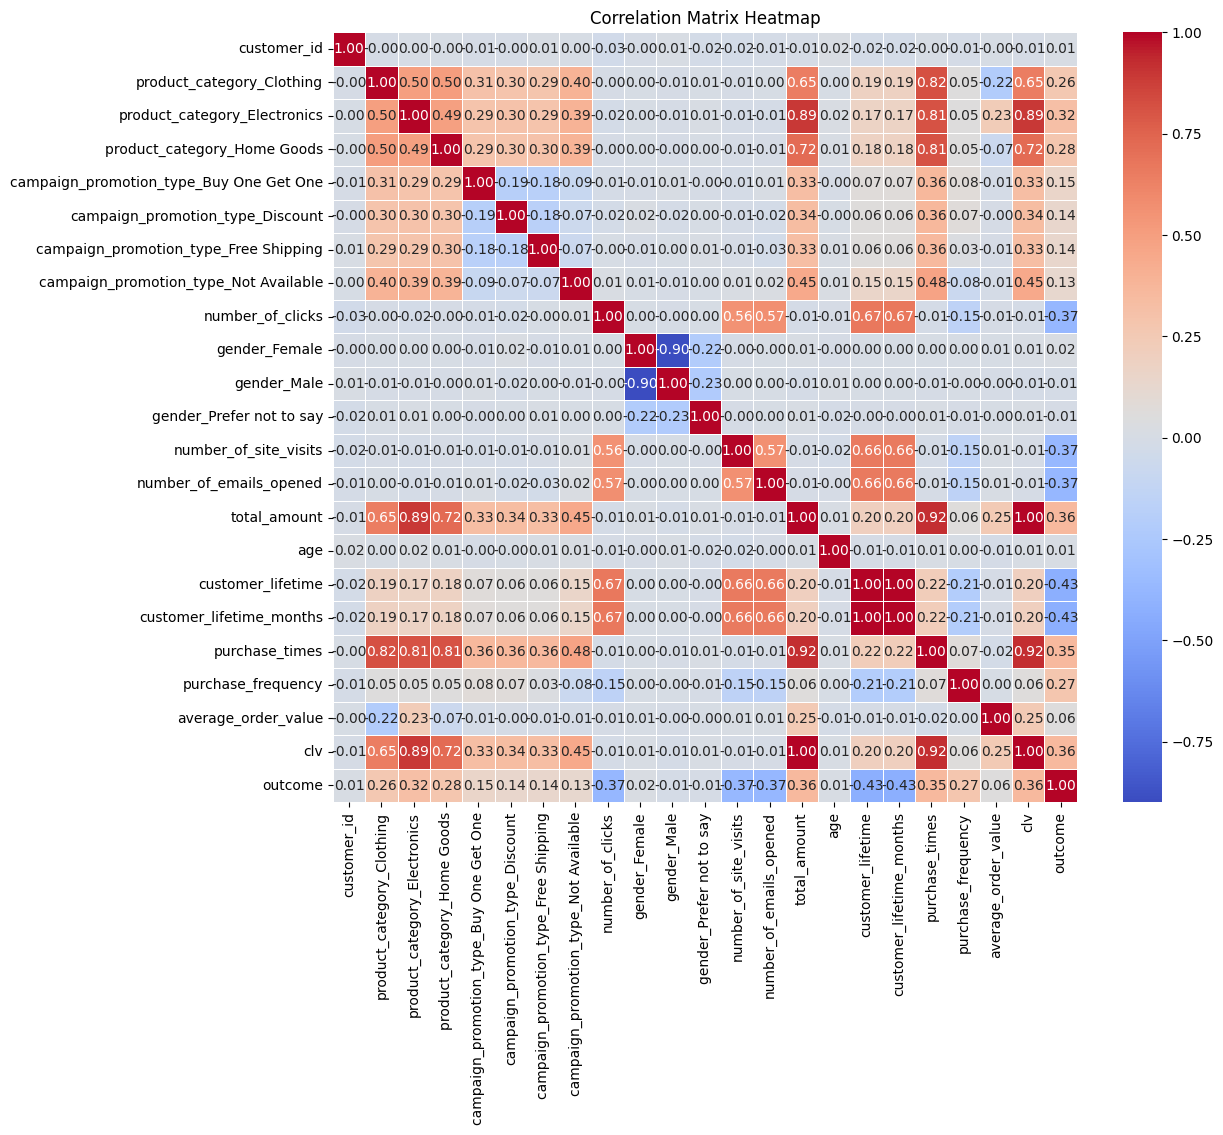

In [741]:
# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

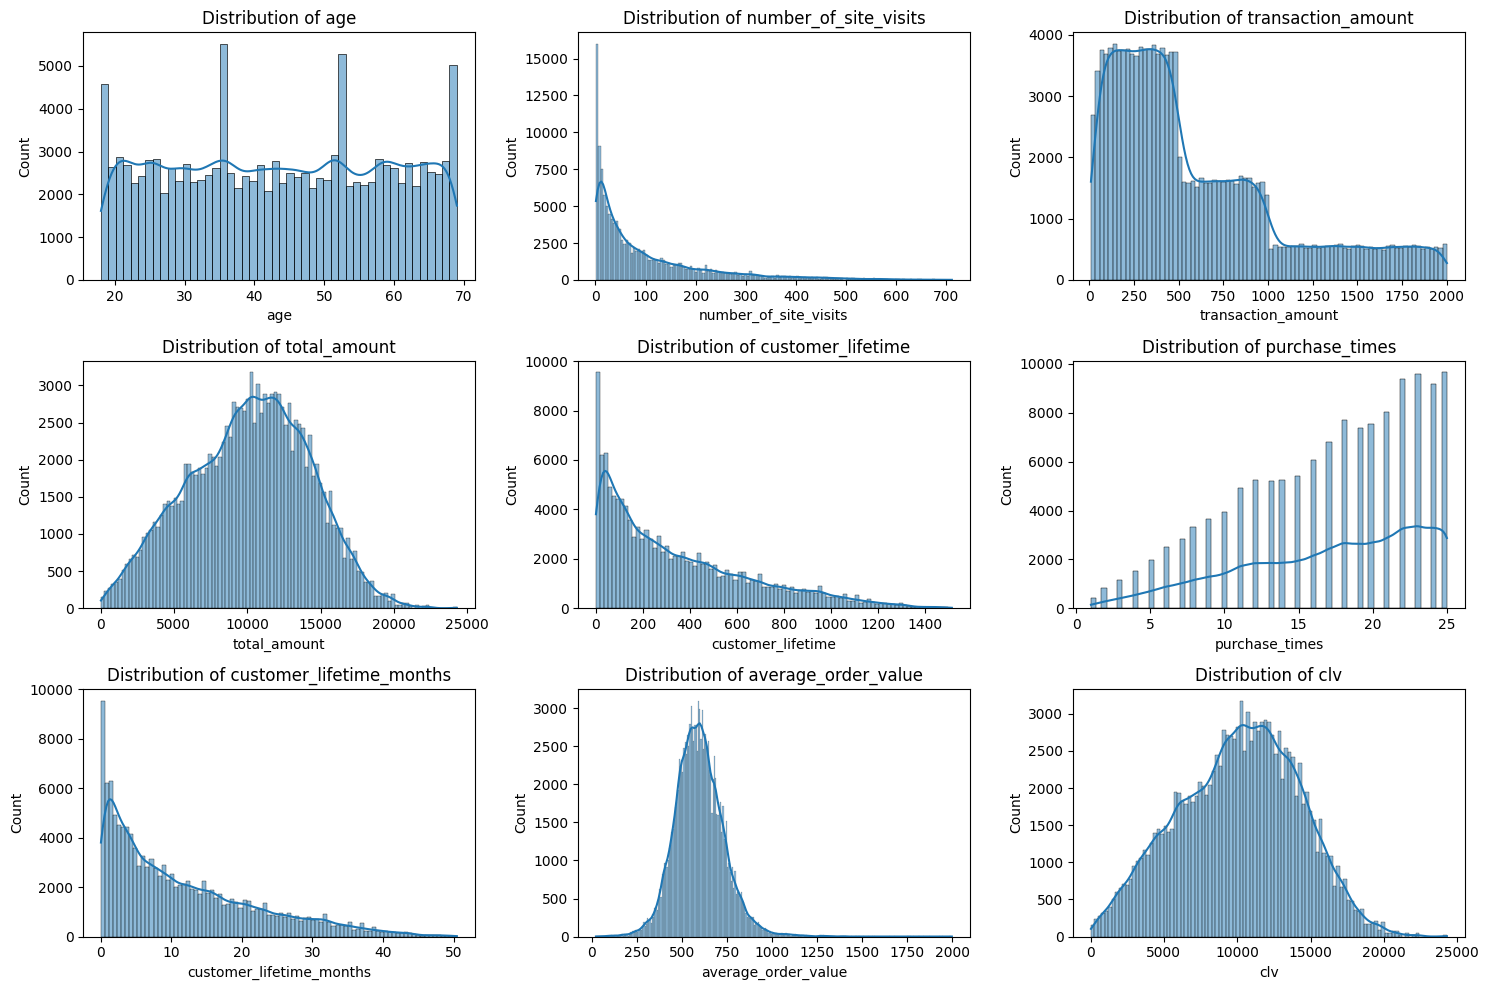

In [742]:
# Distribution of Numerical Features
numerical_features = ['age', 'number_of_site_visits', 'transaction_amount', 'total_amount', 'customer_lifetime', 'purchase_times', 
       'customer_lifetime_months', 'average_order_value', 'clv']

# Plotting the distribution of numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_final[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_17196/886857429.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


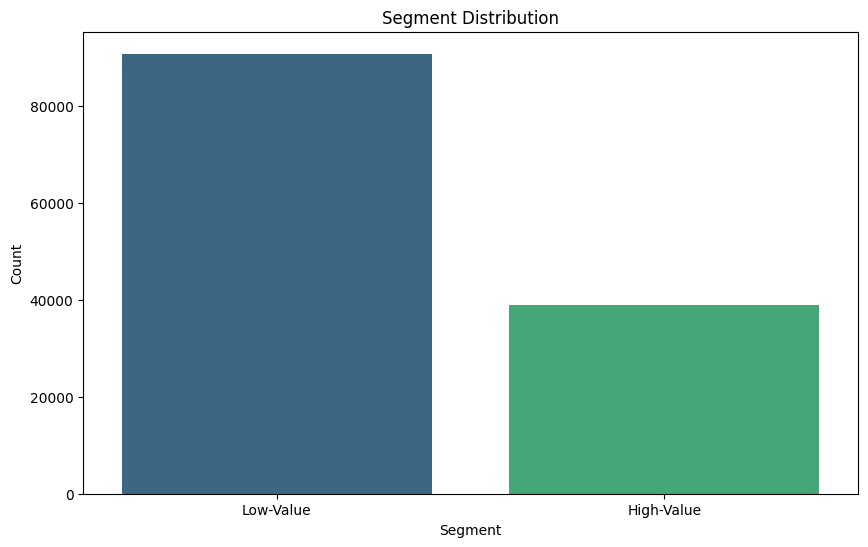

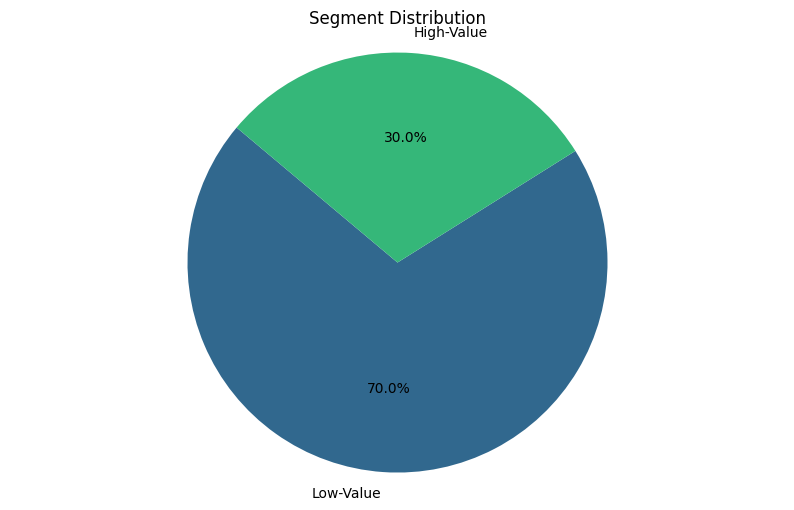

In [743]:
# Count the number of each group
segment_counts = df_final['segment'].value_counts()

# Histogram visualization using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()

# Pie Chart Visualization Using Matplotlib
plt.figure(figsize=(10, 6))
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(segment_counts)))
plt.title('Segment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_17196/1133648849.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_final.set_index('transaction_date').resample('M')['transaction_amount'].sum()


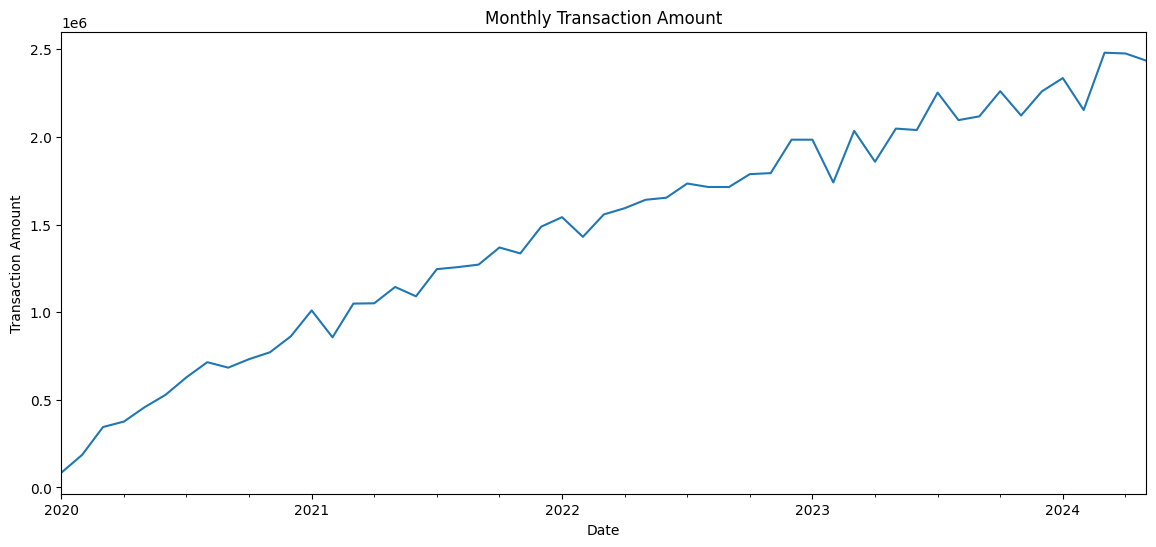

In [744]:
# Transaction amount summarized by month
df_final['transaction_date'] = pd.to_datetime(df_final['transaction_date'])
monthly_sales = df_final.set_index('transaction_date').resample('M')['transaction_amount'].sum()

# Draw a time series graph
plt.figure(figsize=(14, 6))
monthly_sales.plot()
plt.title('Monthly Transaction Amount')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

# Model Building

In [745]:
df_final.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'location',
       'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
       'transaction_date', 'transaction_amount', 'campaign_campaign_id',
       'total_amount', 'customer_lifetime', 'customer_lifetime_months',
       'purchase_times', 'purchase_frequency', 'purchase_frequency_month',
       'average_order_value', 'clv', 'segment', 'outcome', 'gender_Female',
       'gender_Male', 'gender_Prefer not to say', 'product_category_Clothing',
       'product_category_Electronics', 'product_category_Home Goods',
       'campaign_promotion_type_Buy One Get One',
       'campaign_promotion_type_Discount',
       'campaign_promotion_type_Free Shipping',
       'campaign_promotion_type_Not Available'],
      dtype='object')

In [746]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 31 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   customer_id                              129545 non-null  int64         
 1   join_date                                129545 non-null  object        
 2   last_purchase_date                       129545 non-null  object        
 3   age                                      129545 non-null  float64       
 4   location                                 129545 non-null  object        
 5   number_of_site_visits                    129545 non-null  int64         
 6   number_of_emails_opened                  129545 non-null  int64         
 7   number_of_clicks                         129545 non-null  int64         
 8   transaction_date                         129545 non-null  datetime64[ns]
 9   transaction_amount        

### Logistic Regression

In [747]:
model_data = df_final[['age', 'number_of_site_visits', 'number_of_emails_opened', 'transaction_amount',
                      'gender_Female', 'gender_Male', 'gender_Prefer not to say', 
                      'product_category_Clothing', 'product_category_Electronics', 'product_category_Home Goods', 
                      'campaign_promotion_type_Buy One Get One', 'campaign_promotion_type_Discount', 
                      'campaign_promotion_type_Free Shipping', 'campaign_promotion_type_Not Available', 'outcome']]

model_data

,age,number_of_site_visits,number_of_emails_opened,transaction_amount,gender_Female,gender_Male,gender_Prefer not to say,product_category_Clothing,product_category_Electronics,product_category_Home Goods,campaign_promotion_type_Buy One Get One,campaign_promotion_type_Discount,campaign_promotion_type_Free Shipping,campaign_promotion_type_Not Available,outcome
0,56.0,10,15,174.72,1,0,0,1,0,0,0,0,0,1,0
1,56.0,10,15,927.46,1,0,0,0,1,0,1,0,0,0,0
2,56.0,10,15,165.56,1,0,0,1,0,0,0,1,0,0,0
3,56.0,10,15,1395.87,1,0,0,0,1,0,0,1,0,0,0
4,56.0,10,15,699.01,1,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129540,67.0,12,12,452.07,0,1,0,0,0,1,0,1,0,0,0
129541,67.0,12,12,310.95,0,1,0,1,0,0,0,1,0,0,0
129542,67.0,12,12,587.37,0,1,0,0,0,1,0,1,0,0,0
129543,67.0,12,12,34.85,0,1,0,0,0,1,0,1,0,0,0


<Axes: >

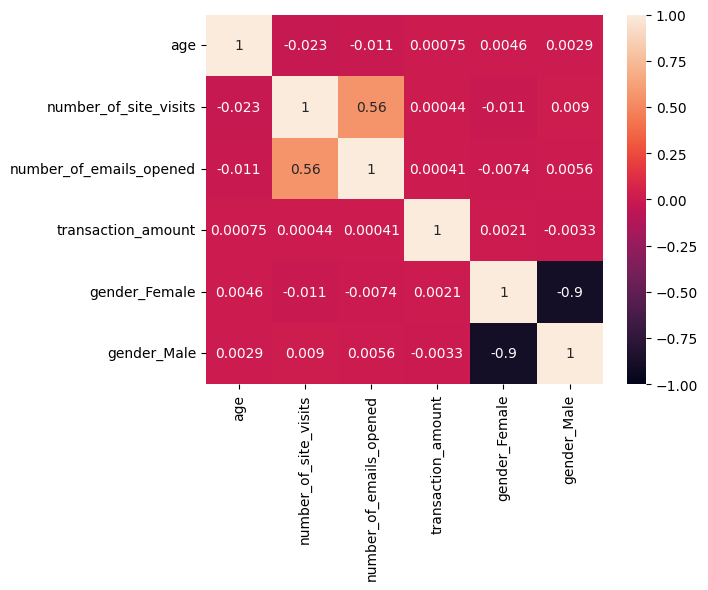

In [748]:
sns.heatmap(model_data.iloc[:, :6].corr(), annot=True, vmin=-1, vmax=1)

In [749]:
X = model_data.drop(columns=['outcome'])  # Feature variables
y = model_data['outcome']  # Target variable

In [750]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [751]:
logreg = LogisticRegression().fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [752]:
# Cross-validation evaluation model
cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC Score: {cv_scores.mean()}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Cross-Validation AUC Scores: [0.94099886 0.91835487 0.93093682 0.93031599 0.92471234]
Mean Cross-Validation AUC Score: 0.9290637759315084


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [753]:
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [754]:
final_scores = pd.DataFrame([y_test.to_list(), y_pred]).T.rename(columns={0:'Actual',1:'Predicted'})
final_scores['difference'] = final_scores['Actual'] - final_scores['Predicted']
final_scores[final_scores['difference']!=0].count() / len(final_scores)

Actual        0.143001
Predicted     0.143001
difference    0.143001
dtype: float64

In [755]:
accuracy_score(y_test, y_pred)

0.8569994982438535

In [756]:
# Evaluate model performance
print("Logistic Regression Model:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Logistic Regression Model:
Confusion Matrix:
[[16015  2135]
 [ 1570  6189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     18150
           1       0.74      0.80      0.77      7759

    accuracy                           0.86     25909
   macro avg       0.83      0.84      0.83     25909
weighted avg       0.86      0.86      0.86     25909


Accuracy Score:
0.8569994982438535


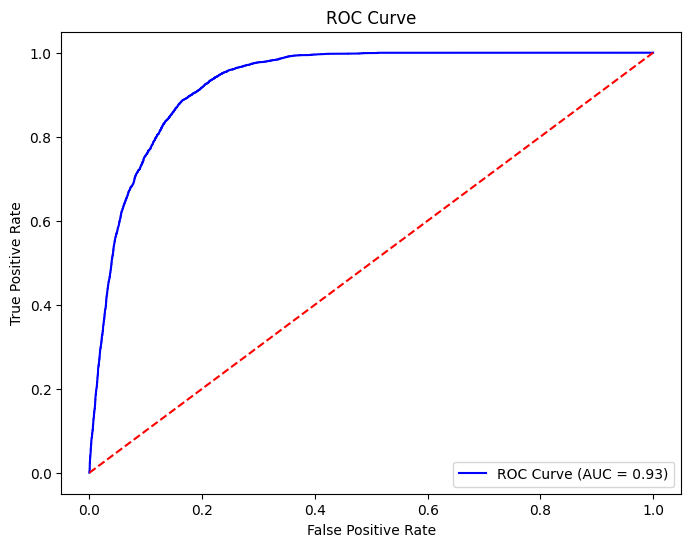

In [757]:
# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Draw ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [758]:
import numpy as np

# Get the feature importance of the model (regression coefficient)
feature_importance = np.abs(logreg.coef_[0])
feature_names = X.columns

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                    Feature  Importance
4                             gender_Female    0.380010
5                               gender_Male    0.340018
9               product_category_Home Goods    0.301345
8              product_category_Electronics    0.300635
7                 product_category_Clothing    0.285054
10  campaign_promotion_type_Buy One Get One    0.269248
12    campaign_promotion_type_Free Shipping    0.232774
11         campaign_promotion_type_Discount    0.209694
13    campaign_promotion_type_Not Available    0.175318
6                  gender_Prefer not to say    0.167005
2                   number_of_emails_opened    0.083659
1                     number_of_site_visits    0.029484
0                                       age    0.003210
3                        transaction_amount    0.000159


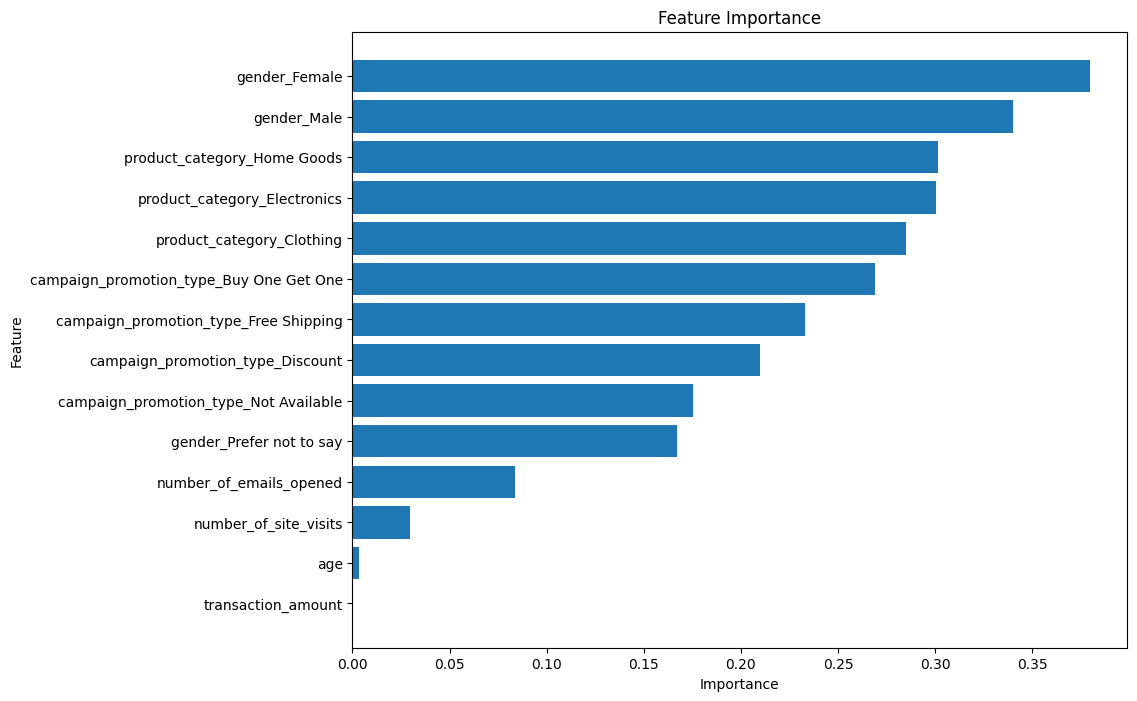

In [759]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the Y axis so the most important features are at the top
plt.show()


### KNN

In [760]:
# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Cross-validation evaluation model
cv_scores = cross_val_score(knn_model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")

# Train the model
knn_model.fit(X_train, y_train)

# predict
y_pred_knn = knn_model.predict(X_test)
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_knn))

Cross-Validation Scores: [0.85190474 0.83191169 0.84217839 0.84186962 0.8352696 ]
Mean Cross-Validation Score: 0.8406268092168745
Confusion Matrix:
[[15956  2194]
 [ 1683  6076]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     18150
           1       0.73      0.78      0.76      7759

    accuracy                           0.85     25909
   macro avg       0.82      0.83      0.82     25909
weighted avg       0.85      0.85      0.85     25909


Accuracy Score:
0.8503608784592227


AUC Score: 0.93


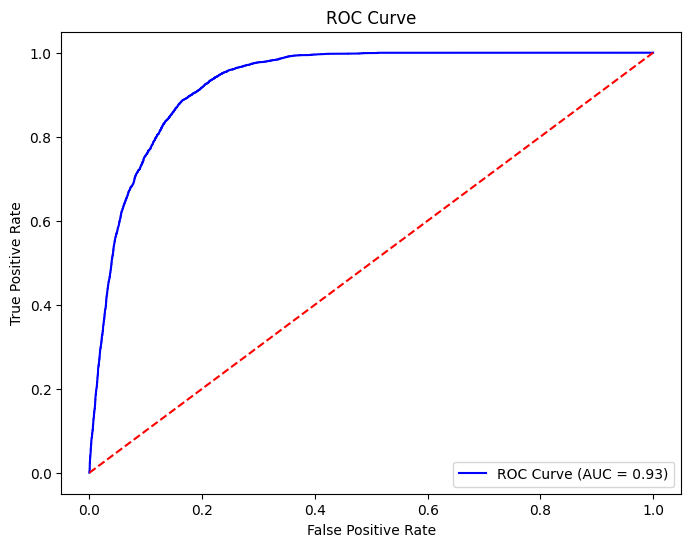

In [761]:
# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Print AUC value
print(f"AUC Score: {auc_score:.2f}")

# Draw ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Random Forest Classification

In [762]:
# Initialize the random forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

# Cross-validation evaluation model
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC Score: {cv_scores.mean()}")

# Train the model
rf_model.fit(X_train, y_train)

# predict
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Random Forest Model:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_rf))


Cross-Validation AUC Scores: [0.93983777 0.9171846  0.93314513 0.92941052 0.92480242]
Mean Cross-Validation AUC Score: 0.9288760872680978
Random Forest Model:
Confusion Matrix:
[[16483  1667]
 [ 1368  6391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     18150
           1       0.79      0.82      0.81      7759

    accuracy                           0.88     25909
   macro avg       0.86      0.87      0.86     25909
weighted avg       0.88      0.88      0.88     25909


Accuracy Score:
0.8828592381025898


AUC Score: 0.95


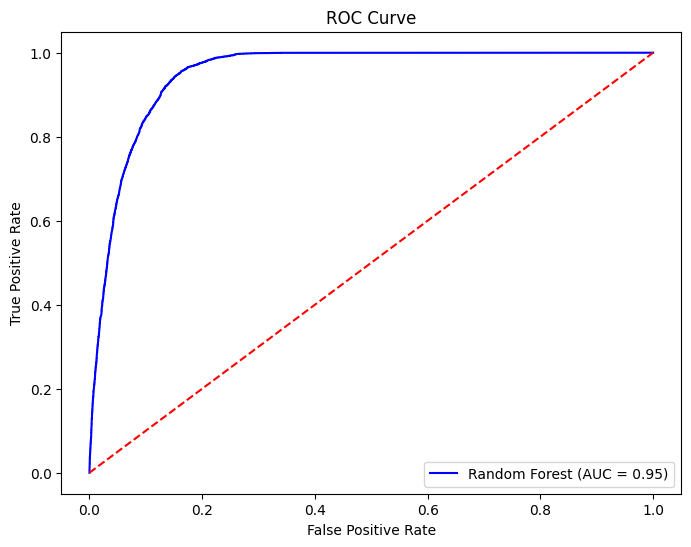

In [763]:
# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
auc_score = roc_auc_score(y_test, y_pred_prob_rf)

# Print AUC value
print(f"AUC Score: {auc_score:.2f}")

# Draw ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

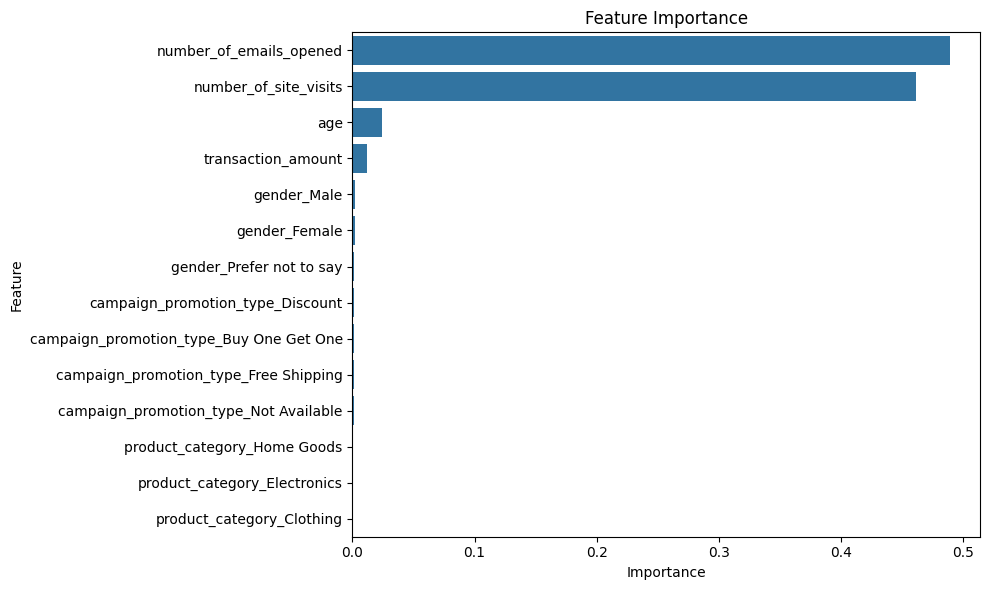

In [764]:
# 获取特征重要性
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# 创建一个DataFrame来显示特征重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Decision tree

In [765]:
# Initialize the decision tree classification model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)

# Cross-validation evaluation model
cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC Score: {cv_scores.mean()}")

# Train the model
dt_model.fit(X_train, y_train)

# predict
y_pred_dt = dt_model.predict(X_test)
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Decision Tree Model:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_dt))


Cross-Validation AUC Scores: [0.89202548 0.84174681 0.87352332 0.86842537 0.86710312]
Mean Cross-Validation AUC Score: 0.8685648222313814
Decision Tree Model:
Confusion Matrix:
[[16604  1546]
 [  900  6859]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     18150
           1       0.82      0.88      0.85      7759

    accuracy                           0.91     25909
   macro avg       0.88      0.90      0.89     25909
weighted avg       0.91      0.91      0.91     25909


Accuracy Score:
0.9055926512022849


AUC Score: 0.96


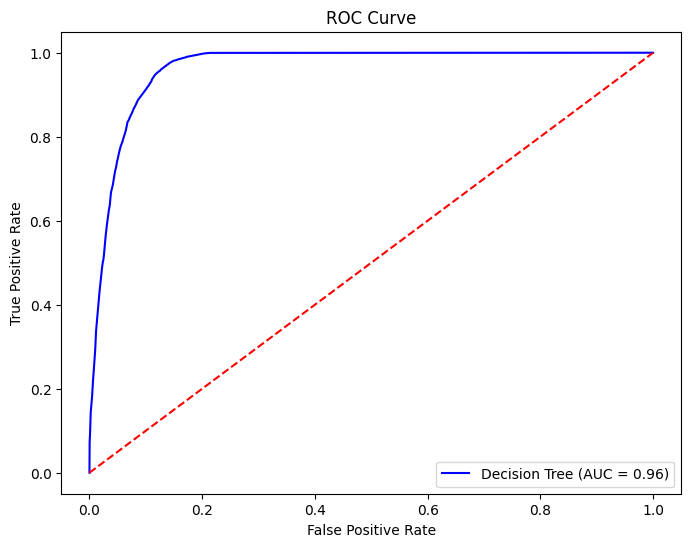

In [766]:
# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
auc_score = roc_auc_score(y_test, y_pred_prob_dt)

# Print AUC value
print(f"AUC Score: {auc_score:.2f}")

# Draw ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Decision Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Model Evaluation